In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
%pylab inline
from scipy.spatial.distance import cdist
from matplotlib.ticker import NullFormatter

Populating the interactive namespace from numpy and matplotlib


In [2]:
sales = pd.read_csv('sales_train.csv')
advert = pd.read_csv('advert_train.csv')

In [3]:
sales.head()

,date,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
0,2008-01-02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,2008-01-03,NaN,1.006943,1.002595,1.006953,1.014819,NaN,1.008989,1.003241
2,2008-01-04,1.015188,NaN,1.043535,1.044507,1.050865,1.025508,1.037337,1.024117
3,2008-01-05,NaN,1.045076,NaN,1.080214,1.071665,NaN,NaN,1.028124
4,2008-01-06,0.995762,1.000988,1.051633,1.056388,1.047756,1.002896,1.027538,0.990433


In [4]:
sales["date"] = pd.to_datetime(sales["date"])
advert["date"] = pd.to_datetime(advert["date"])
sales = sales.interpolate()
sales.isnull().sum()

date        0
market_1    0
market_2    0
market_3    0
market_4    0
market_5    0
market_6    0
market_7    0
market_8    0
dtype: int64

## Understanding how campaing influence our sales

In [9]:
market1 = pd.merge(sales[['date', 'market_1']], advert[['date', 'market_1']], on = 'date')
market1.columns = ['date', 'sales', 'ads']
market1["day_of_the_week"] = market1['date'].dt.weekday_name
market1["month"] = market1['date'].dt.month
market1["year"] = market1['date'].dt.year
market1["day"] = market1['date'].dt.day

In [10]:
market1.head()

,date,sales,ads,day_of_the_week,month,year,day
0,2008-01-02,1.000000,0,Wednesday,1,2008,2
1,2008-01-03,1.007594,0,Thursday,1,2008,3
2,2008-01-04,1.015188,0,Friday,1,2008,4
3,2008-01-05,1.005475,0,Saturday,1,2008,5
4,2008-01-06,0.995762,0,Sunday,1,2008,6


In [11]:
market1.dtypes

date               datetime64[ns]
sales                     float64
ads                         int64
day_of_the_week            object
month                       int64
year                        int64
day                         int64
dtype: object

In [12]:
dummies = pd.get_dummies(market1['day_of_the_week']).rename(columns = lambda x: 'dayoftheweek_' + str(x))
market1 = pd.concat([market1, dummies], axis = 1)

In [13]:
market1.head()

,date,sales,ads,day_of_the_week,month,year,day,dayoftheweek_Friday,dayoftheweek_Monday,dayoftheweek_Saturday,dayoftheweek_Sunday,dayoftheweek_Thursday,dayoftheweek_Tuesday,dayoftheweek_Wednesday
0,2008-01-02,1.000000,0,Wednesday,1,2008,2,0,0,0,0,0,0,1
1,2008-01-03,1.007594,0,Thursday,1,2008,3,0,0,0,0,1,0,0
2,2008-01-04,1.015188,0,Friday,1,2008,4,1,0,0,0,0,0,0
3,2008-01-05,1.005475,0,Saturday,1,2008,5,0,0,1,0,0,0,0
4,2008-01-06,0.995762,0,Sunday,1,2008,6,0,0,0,1,0,0,0


In [14]:
market1.dtypes

date                      datetime64[ns]
sales                            float64
ads                                int64
day_of_the_week                   object
month                              int64
year                               int64
day                                int64
dayoftheweek_Friday                uint8
dayoftheweek_Monday                uint8
dayoftheweek_Saturday              uint8
dayoftheweek_Sunday                uint8
dayoftheweek_Thursday              uint8
dayoftheweek_Tuesday               uint8
dayoftheweek_Wednesday             uint8
dtype: object

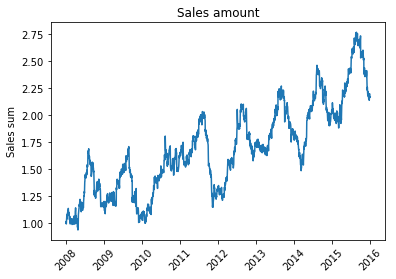

In [15]:
plt.plot(market1["date"], market1['sales'])
plt.title('Sales amount')
plt.ylabel('Sales sum')
plt.xticks(rotation = 45)
plt.show()

The variables whose the correlations  > 0.9: []


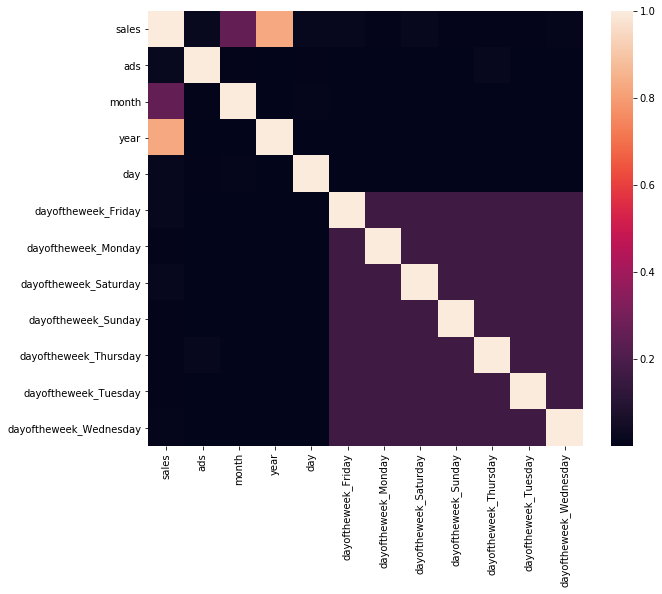

In [16]:
# Calculate the correlation matrix
corr_matrix = market1.corr(method = 'pearson').abs()
f, ax = plt.subplots(figsize = (10, 8))

sns.heatmap(corr_matrix, mask = np.zeros_like(corr_matrix, dtype = np.bool),
            square = True, ax = ax)

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

print('The variables whose the correlations  > 0.9: {}'.format(to_drop) )

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
  market1[["ads", "dayoftheweek_Friday", 'dayoftheweek_Monday', 'dayoftheweek_Saturday', 'dayoftheweek_Sunday', 'dayoftheweek_Thursday', 'dayoftheweek_Tuesday', 'dayoftheweek_Wednesday', "month", 'year', 'day']],
  market1['sales'],
  test_size=0.3,
  random_state = 42 )

In [18]:
print(len(X_train))
print(len(X_test))

2044
877


In [19]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

/anaconda3/envs/MaskRCNN/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [20]:
y_pred = linreg.predict(X_test)
list(zip(["ads", "dayoftheweek_Friday", 'dayoftheweek_Monday', 'dayoftheweek_Saturday', 'dayoftheweek_Sunday', 'dayoftheweek_Thursday', 'dayoftheweek_Tuesday', 'dayoftheweek_Wednesday', "month", 'year', 'day'], list(linreg.coef_ )))


[('ads', 0.18170008333990662),
 ('dayoftheweek_Friday', 0.013871620672583587),
 ('dayoftheweek_Monday', -0.008388968472546113),
 ('dayoftheweek_Saturday', 0.005277816467060858),
 ('dayoftheweek_Sunday', 0.003069548186220358),
 ('dayoftheweek_Thursday', -0.01768697639734326),
 ('dayoftheweek_Tuesday', 0.009233113670715823),
 ('dayoftheweek_Wednesday', -0.005376154126689668),
 ('month', 0.031689296482106735),
 ('year', 0.15084483272331833),
 ('day', 0.0004581071960958118)]

In [21]:
from sklearn import metrics
rmse = np.sqrt( metrics.mean_squared_error( y_test, y_pred ) )
print("RMSE is: " + str(rmse))
print("R^2 is: " + str(metrics.r2_score( y_test, y_pred )))

RMSE is: 0.21040942844108235
R^2 is: 0.7319586905050532


In [22]:
from sklearn.feature_selection import SelectKBest, f_regression
model = SelectKBest(score_func = f_regression)
results = model.fit(X_train, y_train )
['%.3f' % p for p in results.pvalues_]

['0.432',
 '0.453',
 '0.480',
 '0.452',
 '0.681',
 '0.312',
 '0.979',
 '0.836',
 '0.000',
 '0.000',
 '0.342']

Only p-values of month and year are less than 5% - these variables are siginificant in the regression equation.

## Predicting

In [23]:
market1.head()

,date,sales,ads,day_of_the_week,month,year,day,dayoftheweek_Friday,dayoftheweek_Monday,dayoftheweek_Saturday,dayoftheweek_Sunday,dayoftheweek_Thursday,dayoftheweek_Tuesday,dayoftheweek_Wednesday
0,2008-01-02,1.000000,0,Wednesday,1,2008,2,0,0,0,0,0,0,1
1,2008-01-03,1.007594,0,Thursday,1,2008,3,0,0,0,0,1,0,0
2,2008-01-04,1.015188,0,Friday,1,2008,4,1,0,0,0,0,0,0
3,2008-01-05,1.005475,0,Saturday,1,2008,5,0,0,1,0,0,0,0
4,2008-01-06,0.995762,0,Sunday,1,2008,6,0,0,0,1,0,0,0


In [28]:
market1 = market1.set_index('date')
print(market1['date'].min(), market1['date'].max())

KeyError: 'date'

In [29]:
y = market1['sales']#.resample('MS').mean()

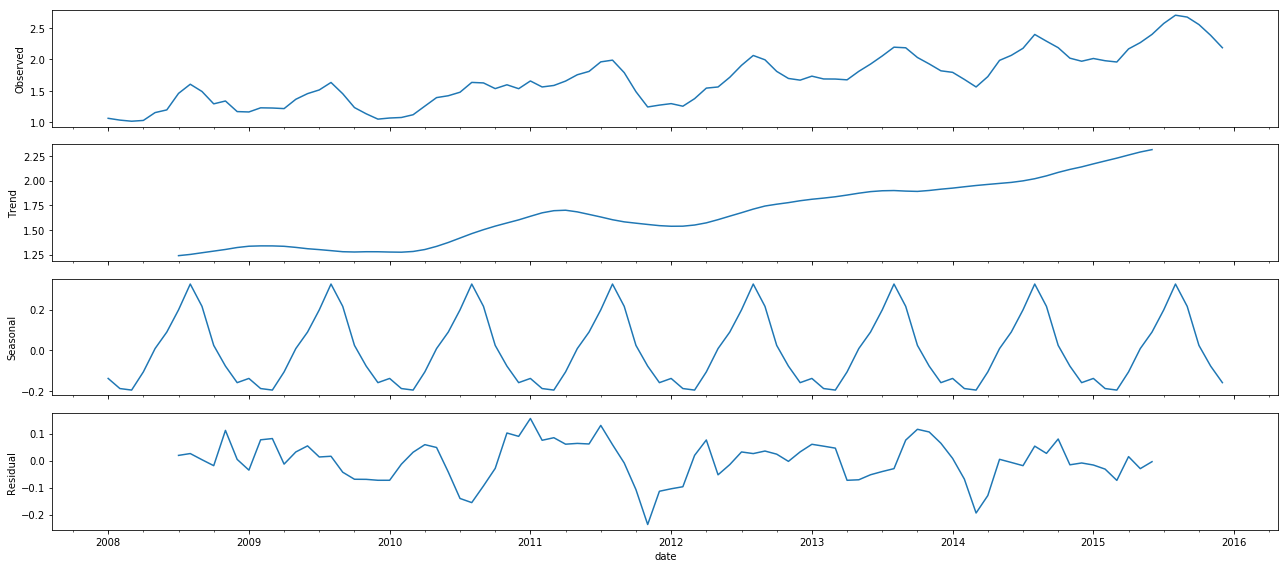

In [30]:
from pylab import rcParams

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(market1['sales'].resample('MS').mean(), model='additive')
fig = decomposition.plot()
plt.show()

In [31]:
import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [32]:
warnings.filterwarnings("ignore")

AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y, order = param, seasonal_order = param_seasonal,
                                            enforce_stationarity = False, enforce_invertibility = False)

            results = mod.fit()
            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end = '\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

In [33]:
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

The smallest AIC is -13370.570137510647 for model SARIMAX(1, 1, 1)x(0, 0, 0, 12)


In [34]:
mod = sm.tsa.statespace.SARIMAX(y, order = SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order = SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity = False, enforce_invertibility = False)

results = mod.fit()

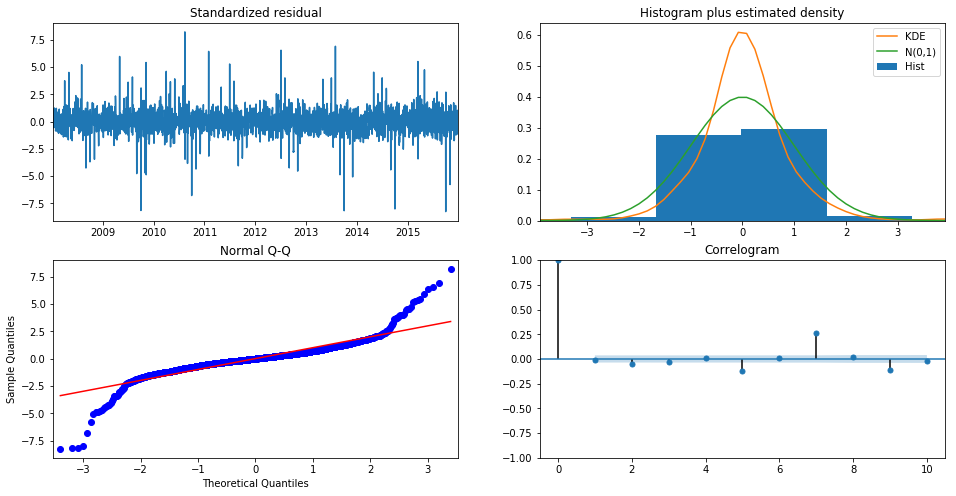

In [35]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

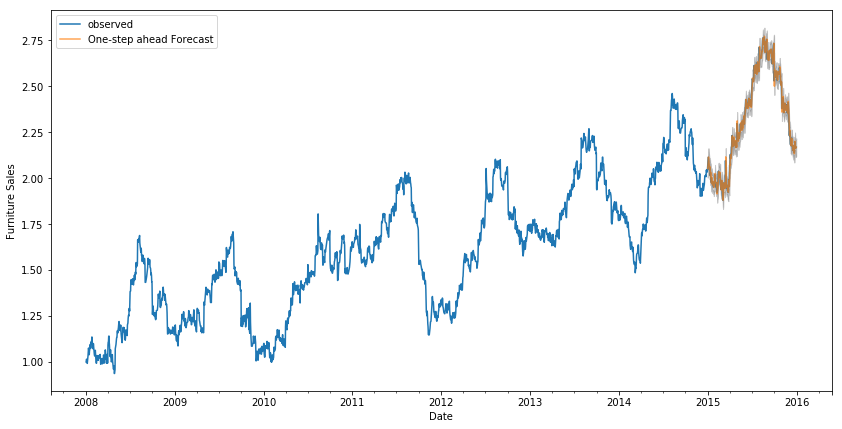

In [36]:
pred = results.get_prediction(start = pd.to_datetime('2015-01-01'), dynamic = False)
pred_ci = pred.conf_int()
ax = y['2008':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha = .7, figsize = (14, 7))
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color = 'k', alpha = .2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [37]:
y_forecasted = pred.predicted_mean
y_truth = y['2015-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.0


In [38]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 0.03


In [80]:
pred_dy = results.get_prediction(start='2016-01-01', dynamic='2017-01-01')
pred_dy_ci = pred_dy.conf_int()

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

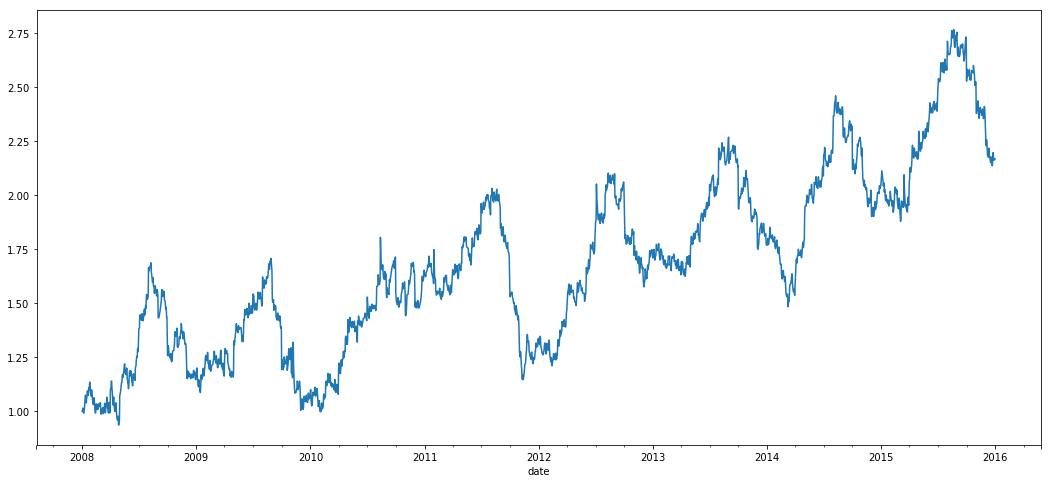

In [81]:
ax = y.plot(label='observed')
pred_dy.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_dy_ci.index,
                pred_dy_ci.iloc[:, 0],
                pred_dy_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_ylabel("Monthly Flights")

# Highlight the forecast area
ax.fill_betweenx(ax.get_ylim(), pd.Timestamp('2013-01-01'), y.index[-1],
                 alpha=.1, zorder=-1)
ax.annotate('Dynamic $\\longrightarrow$', (pd.Timestamp('2013-02-01'), 550))

plt.legend()
sns.despine()

In [60]:
pred2 = results.get_forecast("2017-12-29")
pred2_ci = pred2.conf_int()
print(pred2.predicted_mean['2016-01-01':'2016-01-06'])

2016-01-01    2.167759
2016-01-02    2.167894
2016-01-03    2.167826
2016-01-04    2.167861
2016-01-05    2.167843
2016-01-06    2.167852
Freq: D, dtype: float64


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

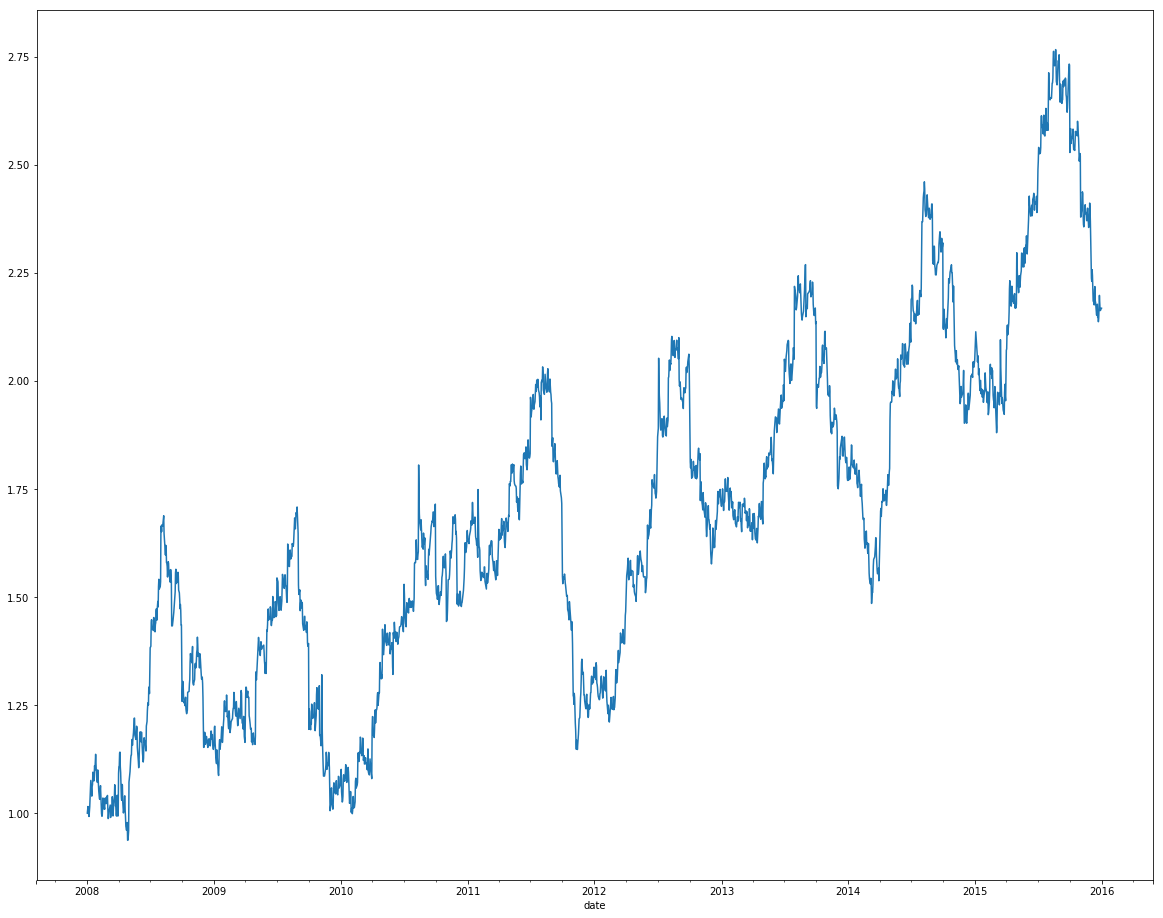

In [79]:
ax = y['2008':].plot(figsize = (20, 16))
pred2.predicted_mean.plot(ax = ax, label = 'Dynamic Forecast (get_forecast)')
ax.fill_between(pred2_ci.index, pred2_ci.iloc[:, 0], pred2_ci.iloc[:, 1], color = 'k', alpha = .1)
plt.ylabel('Monthly airline passengers (x1000)')
plt.xlabel('Date')
plt.legend()
plt.show()

In [ ]:
plt.plot(sales['date'], sales['market_1'])
plt.plot(sales['date'], sales['market_2'])
plt.plot(sales['date'], sales['market_3'])
plt.plot(sales['date'], sales['market_4'])
plt.plot(sales['date'], sales['market_5'])
plt.plot(sales['date'], sales['market_6'])
plt.plot(sales['date'], sales['market_7'])
plt.plot(sales['date'], sales['market_8'])

plt.legend(['Market 1', 'Market 2', 'Market 3', 'Market 4', 'Market 5', 'Market 6', 'Market 7', 'Market 8'], loc = 'upper left')
plt.xlabel('Date')
plt.ylabel('Total sales')
#plt.savefig('forecast.png')
plt.show()

In [ ]:
CBB_PALETTE = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]


def dtw(X, Y, metric='euclidean'):    
    X = np.array(X)
    Y = np.array(Y)
    if len(X.shape) == 1:
        X = X[:, np.newaxis]
    if len(Y.shape) == 1:
        Y = Y[:, np.newaxis]
    m, n = X.shape[0], Y.shape[0]
    D = np.zeros((m+1, n+1))
    D[1:, 0] = np.inf
    D[0, 1:] = np.inf
    D[1:,1:] = cdist(X, Y, metric)
    pointwise_cost = D[1:,1:].copy()
    for i in range(0, m):
        for j in range(0, n):
            cost = D[i+1, j+1]
            D[i+1, j+1] = cost + min (D[i, j+1], D[i+1, j], D[i, j])           
    accumulated_cost = D[1:, 1:]
    total_cost = D[m, n]/sum(D.shape)
    return total_cost, pointwise_cost, accumulated_cost


def get_path(D):
    m , n = D.shape
    m = m - 1
    n = n - 1
    traceback_x, traceback_y = [m], [n]
    while (m > 0 and n > 0):
        min_idx = np.argmin([D[m-1, n-1], D[m, n-1], D[m-1, n]])
        if min_idx == 0:
            m = m - 1
            n = n - 1
        elif min_idx == 1:
            n = n - 1
        else:
            m = m - 1
        traceback_x.insert(0, m)
        traceback_y.insert(0, n)

    traceback_x.insert(0, 0)
    traceback_y.insert(0, 0)
    return np.array(traceback_x), np.array(traceback_y)

def plot_warped_timeseries(x, y, pointwise_cost, 
                           accumulated_cost, path, 
                           colormap=plt.cm.Blues,
                           linecolor=CBB_PALETTE[-2]):
    nullfmt = NullFormatter()    
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02
    rect_heatmap = [left, bottom, width, height]
    rect_x = [left, bottom_h, width, 0.2]
    rect_y = [left_h, bottom, 0.2, height]

    fig = plt.figure(1, figsize=(8, 8))

    axHeatmap = plt.axes(rect_heatmap)
    axX = plt.axes(rect_x, sharex=axHeatmap)
    axY = plt.axes(rect_y, sharey=axHeatmap)

    axX.xaxis.set_major_formatter(nullfmt)
    axY.yaxis.set_major_formatter(nullfmt)
    
    axY.plot(y, range(0, len(y)), color=CBB_PALETTE[2])
    axX.plot(x, color=CBB_PALETTE[1])
    axHeatmap.imshow(accumulated_cost.T, 
                     origin='lower', 
                     cmap=colormap, 
                     interpolation='nearest')
    axHeatmap.plot(path[0], path[1], '-x', color=linecolor)
    return fig

In [ ]:
x = np.array(sales['market_1'])
y = np.array(sales['market_3'])

plt.plot(x, label='Market 1')
plt.plot(y, label='Market 3')
plt.legend()

total_cost, pointwise_cost, accumulated_cost= dtw(x, y, 'euclidean')
path = get_path(accumulated_cost)
_ = plot_warped_timeseries(x, y, pointwise_cost, accumulated_cost, path)

For instance, this time-series are super simular, despite they did not have any marketing activities in common at all.